# Homework 4

# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображении, нормировался, отображался на черный фон и подавался нейронной сети на вход. 

Ваша задача - написать программу, которая совершит предобработку картинки, описанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер и равномерно занимало место, то есть, если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в папке whale_tail/images к этому занятию. Разметка картинок (маски хвостов) лежат в папке whale_tail/ground_truth. После выделения хвоста посчитайте IoU для каждой картинки (ипсользуя маски из whale_tail/ground_truth)

<table><tr>
    <td> <img src="whale_tail/images/test_image_01.jpg" alt="Drawing" style="width: 400px;"/> 
    <td> <img src="whale_tail/ground_truth/test_image_01.png" alt="Drawing" style="width: 400px;"/> </td>
  
</tr></table>

# IoU 
 Intercetion over union - число от 0 до 1, показывающее, насколько у двух объектов (эталонного (ground true) и текущего) совпадает внутренний “объем”.
 
<table><tr>
    <td> <img src="../img/iou.png" alt="Drawing" style="width: 400px;"/> 
  
</tr></table>

Text(0.5, 1.0, 'Preprocessed Tail')

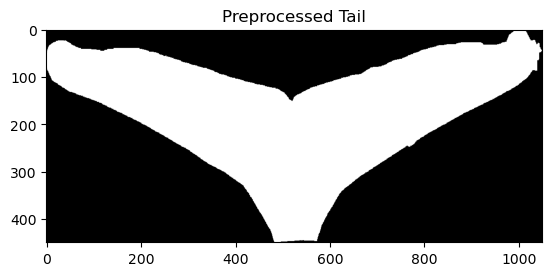

In [6]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# Путь к папке с изображениями и масками
images_path = 'whale_tail/images'
masks_path = 'whale_tail/ground_truth'

# Задаем размер для нормализации изображений хвостов
#desired_size = (256, 256)

def load_image_and_mask(image_path, mask_path):
    # Загрузить изображение
    image = cv2.imread(image_path)
    # Загрузить маску
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return image, mask

def preprocess_tail(image, mask, desired_size):
    # Выделить хвост на изображении, используя маску
    tail = cv2.bitwise_and(image, image, mask=mask)
    
    # Найти контуры маски
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Найти минимальный ограничивающий прямоугольник
        x, y, w, h = cv2.boundingRect(contours[0])
        tail = tail[y:y+h, x:x+w]

    tail_resized = cv2.resize(tail, desired_size)
    

    result = np.zeros((desired_size[1], desired_size[0], 3), dtype=np.uint8)
    
    result[(desired_size[1] - tail_resized.shape[0]) // 2:(desired_size[1] - tail_resized.shape[0]) // 2 + tail_resized.shape[0],
           (desired_size[0] - tail_resized.shape[1]) // 2:(desired_size[0] - tail_resized.shape[1]) // 2 + tail_resized.shape[1]] = tail_resized
    
    return result

def calculate_iou(predicted_mask, ground_truth_mask):
    # Вычислить IoU между предсказанной и истинной масками
    intersection = np.logical_and(predicted_mask, ground_truth_mask)
    union = np.logical_or(predicted_mask, ground_truth_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def find_tail_mask(image):
    # Преобразование изображения в градации серого
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Применение порогового значения для бинаризации изображения
    _, binary_mask = cv2.threshold(gray, 15, 100, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(binary_mask)
    
    # Заполнение маски найденными контурами
    if contours:
        cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)
    
    return mask
    
# Пример использования функции
img_pth  = os.path.join(images_path, 'test_image_00.jpg')
mask_pth = os.path.join(masks_path, 'test_image_00.png')
image, mask = load_image_and_mask(img_pth, mask_pth)
preprocessed_tail = preprocess_tail(image, mask, (mask.shape[1],mask.shape[0]))
#plt.imshow(preprocessed_tail)
# Показать предобработанное изображение хвоста


plt.imshow(cv2.cvtColor(find_tail_mask(preprocessed_tail), cv2.COLOR_BGR2RGB))
plt.title('Preprocessed Tail')

# Задача №2 - Найти шаблон на изображении с помощью HOG и кросс-корреляции

Ваша задача - написать программу, которая сможет найти шаблон одного глаза на нескольких изображениях, в том числе затемненных. Использовать нужно HOG представление изображений, поиск шаблона сделать с помощью кросс-корреляции 

Изображение глаз человека и шаблон, который нужно на нем найти, находятся в папке hog

<table><tr>
    <td> <img src="hog/eye.png" alt="Drawing" style="width: 400px;"/> 
</tr></table>     

<table><tr>
    <td> <img src="hog/eyes.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/eyes_dark.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/woman.jpg" alt="Drawing" style="width: 200px;"/> </td>

</tr></table>

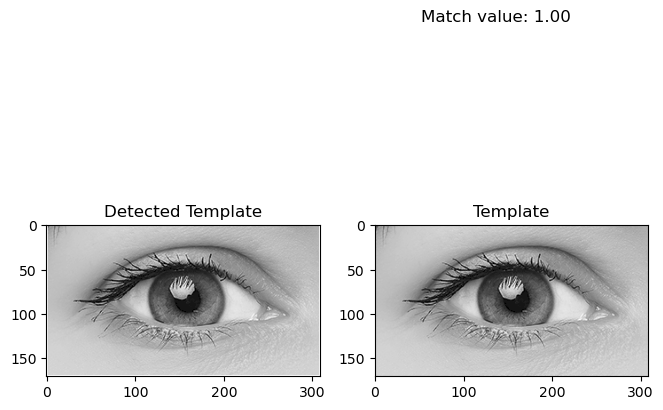

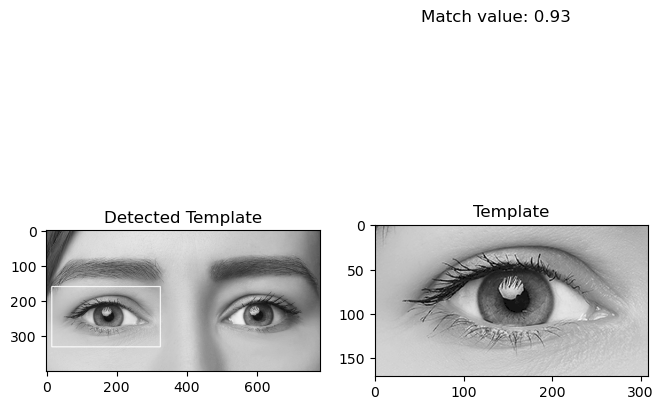

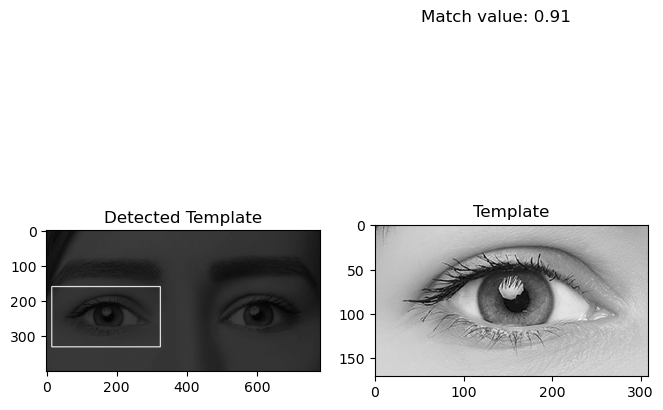

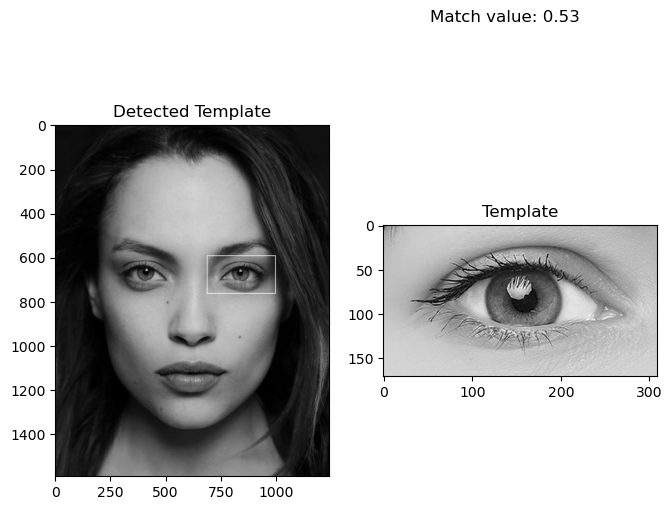

In [8]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
import os


images_path = 'hog/'
template_path = 'hog/eye.png'


def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

def compute_hog(image):
    hog_features, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return hog_features, hog_image


def match_template(image, template):

    image = image.astype(np.uint8)
    template = template.astype(np.uint8)
    
    result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    return max_loc, max_val, result

template = load_image(template_path)
template_hog, template_hog_image = compute_hog(template)


for image_filename in os.listdir(images_path):
    image_path = os.path.join(images_path, image_filename)
    image = load_image(image_path)
    image_hog, image_hog_image = compute_hog(image)

    max_loc, max_val, result = match_template(image_hog_image, template_hog_image)

    h, w = template.shape
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    cv2.rectangle(image, top_left, bottom_right, 255, 2)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Detected Template')
    

    plt.subplot(1, 3, 2)
    plt.imshow(template, cmap='gray')
    plt.title('Template')
    
    plt.suptitle(f'Match value: {max_val:.2f}')
    plt.show()